In [380]:
!wget -O 05_dtw_hmm.tgz https://www.fit.vutbr.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz
!tar -xf 05_dtw_hmm.tgz
!mkdir -p zre
!rm -r zre
!wget -O matrices.mat https://www.fit.vutbr.cz/~ibrukner/ZRE/cvika/matrices.mat
!wget -O zre_lib.zip https://www.fit.vutbr.cz/~ibrukner/ZRE/cvika/zre_lib.zip
!unzip zre_lib.zip

--2025-04-14 15:44:13--  https://www.fit.vutbr.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz
Resolving www.fit.vutbr.cz (www.fit.vutbr.cz)... 2001:67c:1220:809::93e5:917, 147.229.9.23
Connecting to www.fit.vutbr.cz (www.fit.vutbr.cz)|2001:67c:1220:809::93e5:917|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz [following]
--2025-04-14 15:44:13--  https://www.fit.vut.cz/study/courses/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz
Resolving www.fit.vut.cz (www.fit.vut.cz)... 2001:67c:1220:809::93e5:941, 147.229.9.65
Connecting to www.fit.vut.cz (www.fit.vut.cz)|2001:67c:1220:809::93e5:941|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.fit.vut.cz/study/course/ZRE/public/labs/05_dtw_hmm/05_dtw_hmm.tgz [following]
--2025-04-14 15:44:13--  https://www.fit.vut.cz/study/course/ZRE/public/labs/05_dtw_hmm/05_dtw_hm

In [381]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.io
import scipy.signal as sg
import scipy.stats as sts
import librosa
import soundfile as sf
import importlib
from tqdm import tqdm
import os
from IPython.display import Audio

In [382]:
def frame(wavname, ls, rs, Fs):
    # load
    s = librosa.load(wavname, sr = Fs)[0]
    sm = s - np.mean(s)
    # divide signal into frames
    hopsize = ls - rs
    Nram = int(1 + np.floor((len(sm) - ls) / hopsize))
    xram = np.array([sm[i*hopsize:i*hopsize + ls] for i in range(Nram)])
    return xram
ls = 240
rs = 160
Fs = 8000
train_orig = {}
train_orig["1"] = librosa.load('05_dtw_hmm/1.wav', sr = Fs)[0]
train_orig["2"] = librosa.load('05_dtw_hmm/2.wav', sr = Fs)[0]
train_orig["3"] = librosa.load('05_dtw_hmm/3.wav', sr = Fs)[0]
train_orig["4"] = librosa.load('05_dtw_hmm/4.wav', sr = Fs)[0]

train = {}
train["1"] = frame('05_dtw_hmm/1.wav', ls, rs, Fs)
train["2"] = frame('05_dtw_hmm/2.wav', ls, rs, Fs)
train["3"] = frame('05_dtw_hmm/3.wav', ls, rs, Fs)
train["4"] = frame('05_dtw_hmm/4.wav', ls, rs, Fs)

Audio('05_dtw_hmm/2.wav', rate = 8000)

# Audio(05_dtw_hmm/2.wav, rate=8000)
# Audio(05_dtw_hmm/3.wav, rate=8000)
# Audio(05_dtw_hmm/4.wav, rate=8000)

In [383]:
# testing set

test_orig = {}
test_orig["1t"] = librosa.load('05_dtw_hmm/1t.wav', sr = Fs)[0]
test_orig["2t"] = librosa.load('05_dtw_hmm/2t.wav', sr = Fs)[0]
test_orig["3t"] = librosa.load('05_dtw_hmm/3t.wav', sr = Fs)[0]
test_orig["4t"] = librosa.load('05_dtw_hmm/4t.wav', sr = Fs)[0]
test_orig["1l"] = librosa.load('05_dtw_hmm/1l.wav', sr = Fs)[0]
test_orig["2l"] = librosa.load('05_dtw_hmm/2l.wav', sr = Fs)[0]
test_orig["b"] = librosa.load('05_dtw_hmm/b.wav', sr = Fs)[0]

test = {}
test["1t"] = frame('05_dtw_hmm/1t.wav', 240, 160, Fs = 8000)
test["2t"] = frame('05_dtw_hmm/2t.wav', 240, 160, Fs = 8000)
test["3t"] = frame('05_dtw_hmm/3t.wav', 240, 160, Fs = 8000)
test["4t"] = frame('05_dtw_hmm/4t.wav', 240, 160, Fs = 8000)
test["1l"] = frame('05_dtw_hmm/1l.wav', 240, 160, Fs = 8000)
test["2l"] = frame('05_dtw_hmm/2l.wav', 240, 160, Fs = 8000)
test["b"] = frame('05_dtw_hmm/b.wav', 240, 160, Fs = 8000)
Audio('05_dtw_hmm/2t.wav', rate = 8000)

In [384]:
def lpc_coefficients(frame, P):
    R = np.array([np.sum(frame[i:] * frame[:len(frame)-i]) for i in range(P+1)])
    A = np.hstack([[1], np.linalg.inv(scipy.linalg.toeplitz(R[:-1])) @ -R[1:]])

    return A # shape (P+1)

def LPCC(sig_frames, P):
    # P: order of LPC (10)
    LPC = np.array([lpc_coefficients(fr, P) for fr in sig_frames]) # matrix of LPC coefficients, shape: (N,P+1)
    LPC_cepstral = []
    N = P+1

    for frame in range(0, len(sig_frames)):
        c = np.zeros((N+1))
        a = LPC[frame]
        ahelp = np.hstack([a, np.zeros(N - len(a))])
        c[1] = - ahelp[1]
        for n in range(2, N):
            k_s = np.arange(1, n-1)
            c_k_s = c[1:n-1]
            a_n_s = ahelp[n-k_s]
            som = np.sum(k_s*c_k_s*a_n_s)/n
            c[n] = -ahelp[n] - som

        #print(c.shape)
        LPC_cepstral.append(c[1:-1])
    
    print(np.array(LPC_cepstral).shape)
    
    return np.array(LPC_cepstral)

print("test vectors shapes")
LPCCr = [LPCC(sig, P = 10) for sig in train.values()]
LPCC_train = {k: v for k,v in zip(train.keys(), LPCCr)}

print("Test vectors shapes")
LPCCs = [LPCC(sig, P = 10) for sig in test.values()]
LPCC_test = {k: v for k,v in zip(test.keys(), LPCCs)}


test vectors shapes
(55, 10)
(40, 10)
(36, 10)
(49, 10)
Test vectors shapes
(47, 10)
(38, 10)
(30, 10)
(51, 10)
(64, 10)
(80, 10)
(44, 10)


## LAB 6 : Hidden Markov Models (HMM)
Let's build a recognition system based on HMM.
### 1.1. Markov chain
![HMM.PNG](img/HMM.PNG)

1) Set of states: $\mathbf{Q} = q_0, ..., q_N $
where $q_0$ is the input and state $q_N$ the output
the number of transition states is then $N - 2$ 

2) $\textbf{Transition probability matrix A}$
$$\begin{bmatrix}
a_{0,0} & a_{1,0} & ... & a_{0,N}\\
...\\
a_{N,0} & a_{N,1} & ... & a_{N,N}
\end{bmatrix}
$$
where each $a_{ij}$ represents the probabiility of moving from state $i$ to state $j$.

For speech recognition: from $i-th$ state you can stay or go to the next one (no going back)



#### Q: How many states would you consider based on the recordings? Why?

In [385]:
O = LPCC_train["1"].T
# number of frames:
T = O.shape[1] #55
# number of LPCC coeff:
P = O.shape[0] #10
# number of HMM states
N = 9

#### Q: How will the non-zero values in matrix A be distributed in our case? What additional constraint do the values in matrix A have?

In [ ]:
def inittran(N):
    s_p, n_p = 0.5, 0.5
    A = np.zeros((N,N))
    A[0,1] = 1
    for i in range(1, N-1):
        A[i,i] = s_p
        A[i,i+1] = n_p
    return A

A = inittran(N)
A

- $n_p$ : probability of going to the next state is set to 0.5
- $s_p$ : probability of not changing state is se to 0.5

3) $\textbf{Set of observations O}$: we have a initial set of observations ${o_0, ..., o_T}$

$$ O = [o_0, ..., o_T] = 
\begin{bmatrix}
o_{0,0} & o_{1,0} & ... & o_{0,T}\\
...\\
o_{P,0} & o_{P,1} & ... & o_{P,T}
\end{bmatrix}
$$
where $T$ is the number of observations (frames) and $P$ is the number of coefficients describing each state (LPCC).

In [387]:
O = LPCC_train["1"].T
O.shape

(10, 55)

### 1.2 Hidden Markov Model: calculate likelihoods
we defined states and the transition probabilities, now let's define a Hidden markov model, which has the same form as a Markov chain, but the form of the transition states $Q$ is unknown

---> we use **probability distribution** for every possible state (Gaussian)

Remember :
- P = number of LPC coefficients
- N = number of states of Markov Chain
- T = number of frames of input signal (observations)

#### Q: What Gaussians will we need? How will the variance and the mean look like?

1) Initialize the Gaussian - $\Sigma$, $\mu$

In [388]:
O.shape # 10,55
np.mean(O, axis=1)

array([ 1.23340808, -0.68754568,  0.45490301,  0.19938327, -0.47581286,
        0.09491557,  0.1976114 , -0.45287622,  0.02875715,  0.59397429])

In [ ]:
def initemis(O, N):
    empty = ###
    mus = ###
    sigmas = ###
    return mus, sigmas
N = 9 # number of states
P = 10 # number of LPCC coeff (O.shape[0])
MI, SIGMA = initemis(O,N)
print("mus shape")
print(MI.shape)
print("sigmas shape")
print(SIGMA.shape)

mus shape
(9, 10)
sigmas shape
(9, 10)


### 1.3 Baum-Welch re-estimation.
Forward-backward algorithm.


#### 1.3.1 ALPHA - Forward algorithm
In the forward part calculate the cells of matrix $\alpha$, which represents the probability of being in state $j$ after seeing the first $t$ observations.
$$ \alpha(j, t) = P(o_1, ..., o_t, q_t = j)$$
The estimation of these forward likelihoods is done by summing the likelihoods of all trajectories that bring to state $j$ at time $t$ given the initial state $1$
$$ \alpha(j, t) = \displaystyle\sum_{i=1}^N \alpha(i, t-1) a_{ij} b_j(o(t)) $$

Initialization for t = 0:


Initial state $\alpha_0$ given by the initial state distribution and the likelihood of the observations $b_j(o(t))$:
$$ \alpha(j, t = 0) = A[s = 0, j]b_j(o(t))$$

In [ ]:
# N: number of states (9)
# P: number of LPCC coeff - dimensions of Gaussian (11)
# T: number of frames at input (55)
# O: observations - shape P,T
# MI: matrix of mean values: shape (NxP)
# SIGMA: matrix of covariances: shape (NxP)
# A: transition probabilities matrix (NxN)

ALFA = np.zeros((N, T), dtype=np.double) # forward probs
NORMA = np.zeros(T)

#alfa[state, time]
ALFA[0,0] = 1
for j in range(1,N-1): # j = 0 is init, j = N is end state
    init = ###
    emis = ### # observation probability b_j --> gaussian pdf
    ALFA[j, 0] = ###
NORMA[0] = np.max(ALFA[:, 0])
ALFA[:, 0] = ALFA[:, 0] / NORMA[0]

Other time steps: $$\alpha(j,t) = b_j(o(t))\displaystyle\sum_{i=1}^{N-1} \alpha(i, t-1)A(i,j) $$

In [394]:
t = 1
j = 1
ALFA[1:N-1, t-1] * A[1:N-1, j]

array([0.0001574, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       ])

In [ ]:
# ALFA for step 1:T
for t in range(1,T): # over frames(t)
    
    for j in range(1,N-1): # over states
        suma = ### # sum of probs
        emis = ### 
        ALFA[j, t] = suma*emis

    NORMA[t] = np.max(ALFA[:, t])
    if t != T-1:
        ALFA[:, t] = ALFA[:, t] / NORMA[t]


array([0.00000000e+00, 1.28988918e-11, 6.96540159e-10, 1.84583142e-08,
       3.19944113e-07, 4.07928744e-06, 4.07928744e-05, 3.33141808e-04,
       0.00000000e+00])

Termination:

In [ ]:
suma = np.sum(ALFA[1:N-1, T-1] * A[1:N-1, N-1], axis=0)
ALFA[N-1, T-1] = suma
NORMA[T-1] = np.max(ALFA[:, T-1])
ALFA[:, T-1] = ALFA[:, T-1] / NORMA[T-1]


array([0.00000000e+00, 3.87189225e-08, 2.09082181e-06, 5.54067781e-05,
       9.60384154e-04, 1.22448980e-02, 1.22448980e-01, 1.00000000e+00,
       5.00000000e-01])

#### Q : Will all states contribute equally to the forward probability of the current state? Why?

#### 1.3.2 BETA - backward algorithm

We now calculate similarly the matrix Beta, which represents the probabilities of seeing the observation from time $t+1$ to the end, given that we are in state $i$ at time $t$.
$$ \beta(i,t) = P(o_{t+1}, o_{t+2}, ...o_T|q_t = i)

Initialization for t = T-1:
$$\beta(i, T-1) = A(i, N-1), 1\leq i\leq (N-1)$$

In [ ]:
# BETA
BETA = np.zeros((N, T), dtype=np.double) # backward probs
NORMB = np.zeros(T)

for i in range(1,N-1):
    BETA[i, T-1] = A[i, N-1]
NORMB[T-1] = np.max(BETA[:, T-1])
BETA[1:N-1, T-1] = BETA[1:N-1, T-1] / NORMB[T-1]


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0

Other steps from t = T-2 to t = 1:
$$ \beta(i, t) = \displaystyle\sum_{j=1}^N A(i,j)b_j(o(t+1))\beta(j, t+1)

In [399]:
np.arange(T-2, -1, -1)

array([53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37,
       36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20,
       19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,
        2,  1,  0])

In [ ]:
for t in np.arange(T-2, -1, -1):
    for i in range(1, N-1):
        suma = 0
        for j in range(1,N-1):
            suma +=  ###
        BETA[i, t] = suma
    NORMB[t] = np.max(BETA[:, t])
    if t != 0:
        BETA[:,t] = BETA[:,t]/NORMB[t]



Termination, t=0 - same calculation, mind the t = 0

In [ ]:
suma = 0
for j in range(1,N-1):
    suma = ###

BETA[0,0] = suma

NORMB[0] = np.max(BETA[:,0])
BETA[:,0] = BETA[:, 0] / NORMB[0]

#### 1.3.3 Posterior probabilities L
![image.png](img/joint_prob_HMM.PNG)

calculate the prosterior probabilities of being in state $j$ in time $t$ (“soft occupation counts”)
    $$
    L_j(t) =\frac{\alpha_j(t)\beta_j(t)}{P(\mathbf{O}|\lambda)},
    $$
    where $P(\mathbf{O}|\lambda)$ is the Baum-Welch likelihood (sum of the likelihoods of all trajectories) - lambda is the Markov model we are considering.
    
$$P(O|\lambda) = \displaystyle\sum_{j=1}^N \alpha(j, t)\beta(j,t) $$


#### Q: Do you need to compute $P(O|\lambda)$? Where do you have it already calculated?

#### Q: What characteristic (constraint) will the values of L have?

In [ ]:
# Normalization of values

PNA = np.zeros(T)
PNB = np.zeros(T)
for t in range(T):
    PNA[t] = np.prod(NORMA[:t+1])
for t in np.arange(T-1, -1, -1):
    PNB[t] = np.prod(NORMB[t:])

Ptot = PNA[-1] * ALFA[-1,-1]
Ptott = PNB[0] * BETA[0,0]
ALFA = (np.ones((N, 1)) * PNA) * ALFA
BETA = (np.ones((N, 1)) * PNB) * BETA

# Calculation of L
L = ###

In [403]:
L.shape

(9, 55)

#### Q:  What is PNA and PNB? Why do we multiplicate the results by these vectors? What happens if we don't? Try

#### 1.3.4 Updates of ALPHA, BETA and L - Maximum likelihood estimation
update the parameters of the HMM by calculating the weighted average, where $L_j(t)$ are the weights of the vectors. We get:

- updated probabilities' matrix $\mathbf{A}$
$$a_{new}(i,j) = \displaystyle\frac{E\{\text{n. of transitions from i to j}\}}{E\{\text{number of transitions from state i}\}}$$
$$ a_{new}(i,j) = \displaystyle\frac{\sum_T\alpha(i,t)a(i,j)b_j(o(t+1))\beta(j, t+1)}{\sum_T\alpha(i,t)\beta(i,t)}$$
- updated mean values matrix **MI**
$$ \mu_{j,P} = \displaystyle\frac{\sum_{t=1}^TL_j(t)o_P(t)}{\sum_{t=1}^TL_j(t)}$$
- updated std matrix **SIGMA**
$$ \sigma_{j,P} = \displaystyle\frac{\sum_{t=1}^TL_j(t)(o_P(t)-\mu_{j,P})^2}{\sum_{t=1}^TL_j(t)}$$
- the overall probability $P_{tot}$
$$P(O|\lambda) = \displaystyle\sum_{j=1}^N \alpha(j, t)\beta(j,t) $$


Not necessary, functional, outputs:
- **ALFA**: matrix of forward probabilities
- **BETA**: matrix of backward probabilities
- **L**: posterior probabilities (state likelihood)

In [ ]:
# updates

NEWA = np.zeros_like(A)
NEWMI = np.zeros_like(MI)
NEWSIGMA = np.zeros_like(SIGMA)

for i in range(1, N-1):
    for j in range(1, N-1):
        num = 0
        den = 0
        for t in range(T-1):
            num += ###
        for t in range(T):
            den += ###
        NEWA[i,j] = num / den

for j in range(1, N-1):
    NEWA[0,j] = ALFA[j, 0] * BETA[j,0] / Ptot
    
# NEWA[:,-1] - t = T
for i in range(1, N-1):
    num = ALFA[i, -1]*BETA[i, -1]
    den = 0
    for t in range(T):
        den += ALFA[i,t]*BETA[i,t]
    NEWA[i,-1] = num/den

L = ###

for j  in range(1, N-1):
    Lvec = L[j, :]
    Lmat = np.ones((P, 1)) @ Lvec[np.newaxis,:]
    NEWMI[j, :] = np.sum(Lmat * O, axis=1) / np.sum(Lvec)

    NEWSIGMA[j, :] = np.sum(Lmat * ((O - NEWMI[j, :, np.newaxis]@ np.ones((1, T)))**2), axis=1) / np.sum(Lvec)

In [ ]:
def reestim(O, A, MI, SIGMA):
### Just merge cells above to create the estimation function :)

    return NEWA, NEWMI, NEWSIGMA, Ptot, ALFA, BETA, L.T

### 2.1 Word recognition
At the input we have an uknown signal $O$, and $M_i$ models to compare it to. We use the Viterbi probability and determine the most probable word- that's the recognized word.

The function viterbi_log outputs the logarithm of the Viterbi probability $P^*$ and the vector $X$ which saves the optimal sequence of states for the given sequence and model. 


#### 2.1.1 Initialization
Initialize the model with the first train word, "jedna"


In [441]:
N = 9
A = inittran(N)
O = LPCC_train["1"].T
MI, SIGMA = initemis(O,N)

#### Q: Check if the matrix of state probabilities avoids the steps that go back in time - is it correct?

#### Q: How will the occupation counts matrix $L_j(t)$ look like after the initialization? Why?

#### 2.1.2  Baum-Welch – 1. iteration
Calculate the matrices $\alpha_j(t)$ a $\beta_j(t)$ from the initialization parameters, then calculate $L_j(t)$ (for all vectors, all states) and update the model.

The **BW likelihood $P_{tot}$** calculates how the model is accurate.

In [442]:
NEWA, NEWMI, NEWSIGMA, Ptot, ALFA, BETA, L = reestim(LPCC_train["1"], A, MI, SIGMA)

#### Q: Check if the values of $L_j(t)$ are valid (according to their definition)

In [410]:
L.shape

(55, 9)

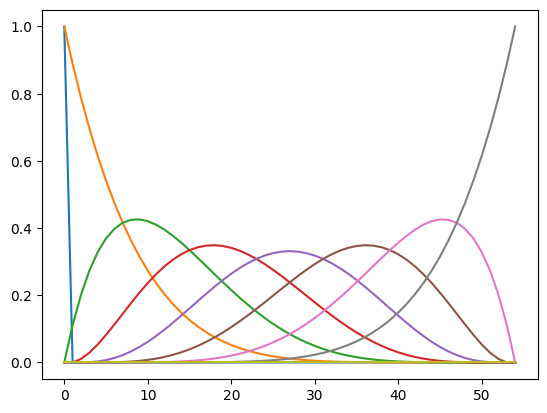

In [443]:
T = LPCC_train["1"].shape[0]
for j in range(L.shape[1]):
    plt.plot (np.arange(T), L[:,j])
plt.show()


#### Q: Compare with the audio does the vector distributions have something in common with the speech you hear? What?

#### 2.1.3  Baum-Welch - 2nd iteration
Calculate  $L_j(t)$ from new parameters and update the outputs (MI, SIGMA, ALFA, BETA)

In [444]:
NEWA,NEWMI,NEWSIGMA,Ptot,ALFA,BETA,L = reestim(LPCC_train["1"], NEWA, NEWMI, NEWSIGMA)
print(Ptot)

C:\Users\uzivatel\AppData\Local\Temp\ipykernel_29544\1174567361.py:85: RuntimeWarning: invalid value encountered in scalar divide
  NEWA[i,j] = up / down


0.0


C:\Users\uzivatel\AppData\Local\Temp\ipykernel_29544\1174567361.py:88: RuntimeWarning: invalid value encountered in scalar divide
  NEWA[0,j] = ALFA[j, 0] * BETA[j,0] / Ptot
C:\Users\uzivatel\AppData\Local\Temp\ipykernel_29544\1174567361.py:95: RuntimeWarning: invalid value encountered in scalar divide
  NEWA[i,-1] = up/down
C:\Users\uzivatel\AppData\Local\Temp\ipykernel_29544\1174567361.py:97: RuntimeWarning: invalid value encountered in divide
  L = ALFA * BETA / Ptot


`Ptot` is zero, let's check $L_j(t)$:

In [413]:
L

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, 

During the reestimation the values of stds were very low, we got division by zero --> nans. 

This is why the covariance matrix Sigma is frozen and the updates are made just on **A** and **MI**.

#### Q: What is the risk of not updating sigma?

--- iteration 0 ---
4.7805751620669746e-188


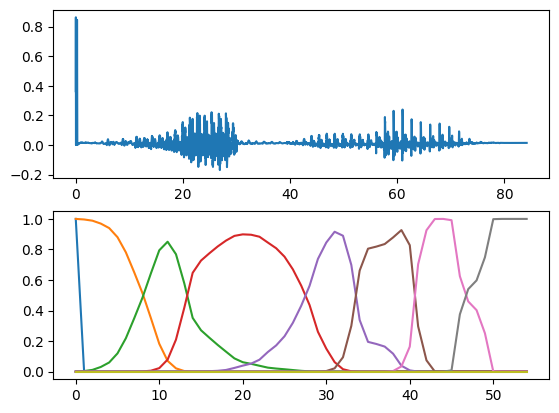

--- iteration 1 ---
1.947664218706014e-164


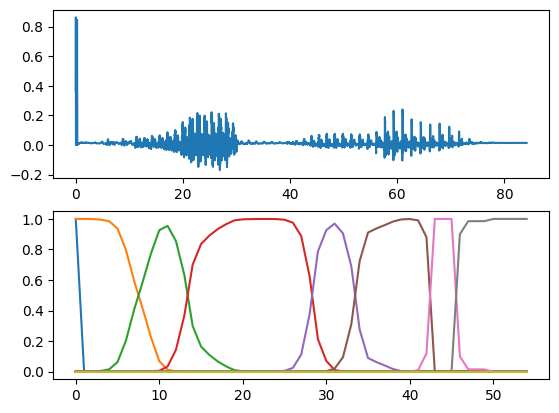

--- iteration 2 ---
2.861395116179067e-155


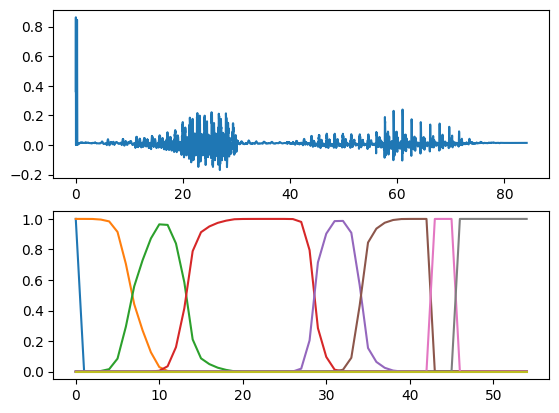

--- iteration 3 ---
1.6495069048428655e-154


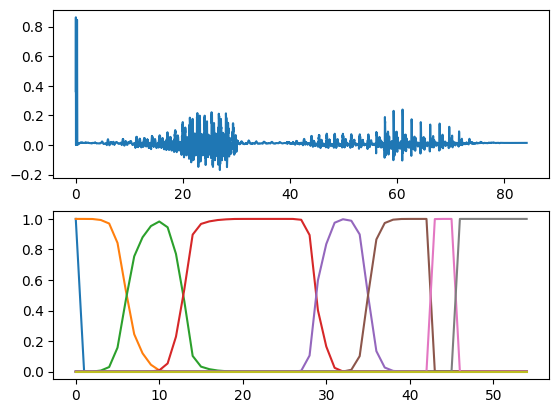

--- iteration 4 ---
1.0574745849274138e-153


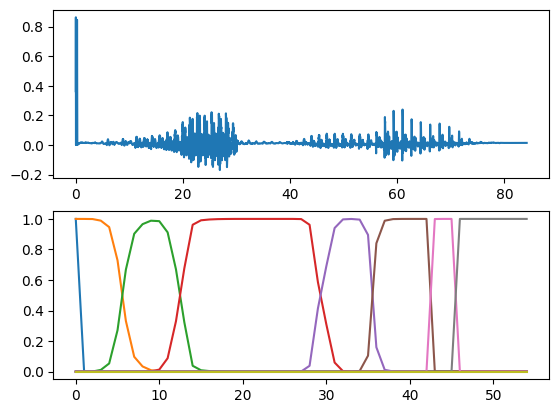

--- iteration 5 ---
2.936309888940843e-153


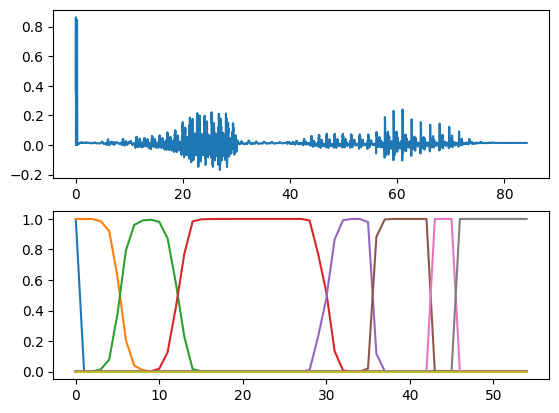

--- iteration 6 ---
3.968638314462712e-153


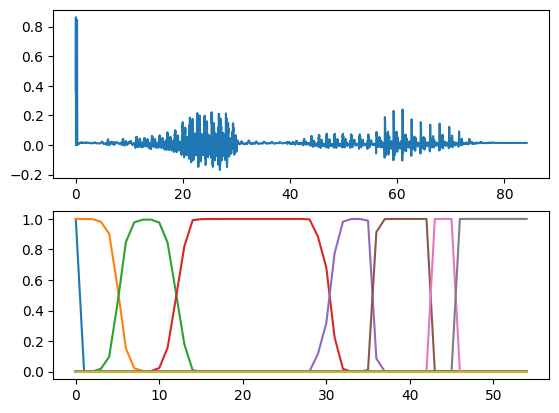

--- iteration 7 ---
4.454505706787676e-153


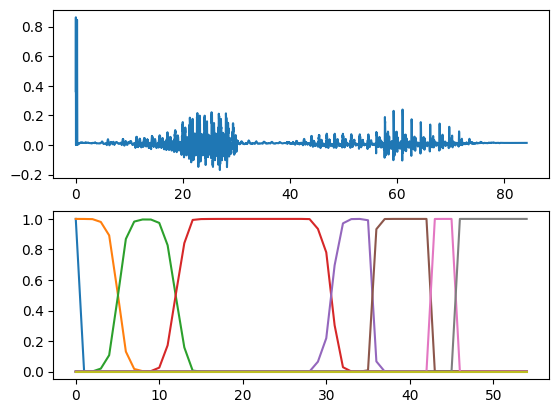

--- iteration 8 ---
4.663648079382471e-153


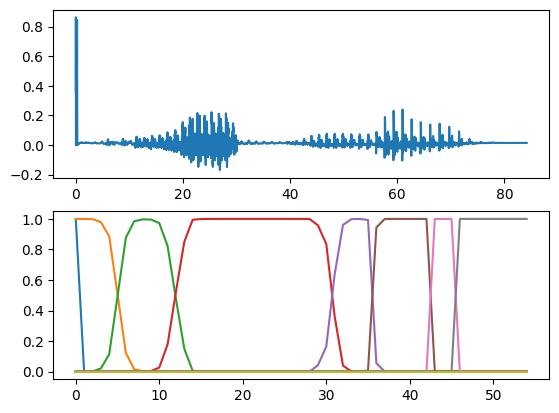

--- iteration 9 ---
4.7472618856806323e-153


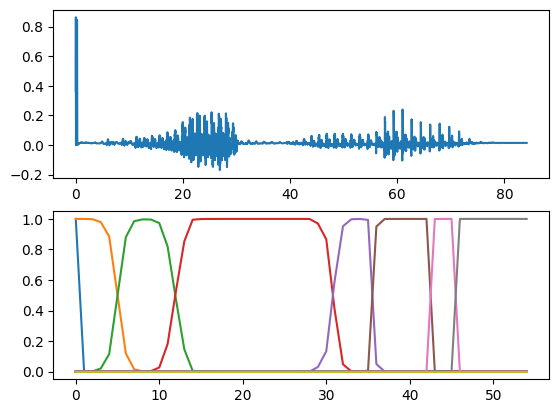

--- iteration 10 ---
4.779171592408614e-153


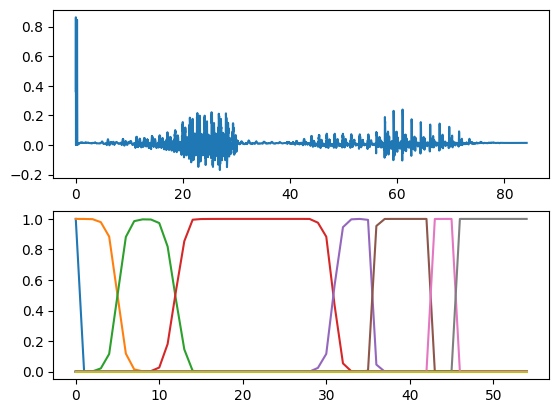

--- iteration 11 ---
4.791060102519603e-153


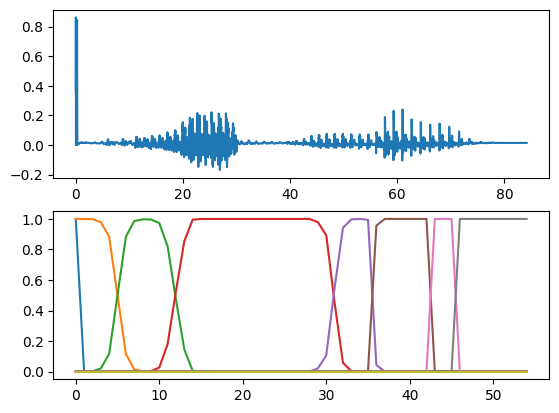

--- iteration 12 ---
4.795441766314351e-153


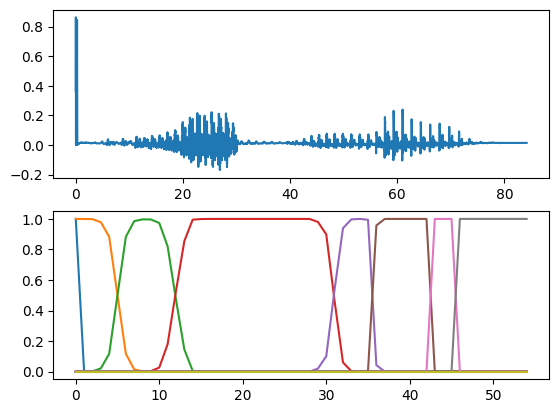

--- iteration 13 ---
4.797049674596737e-153


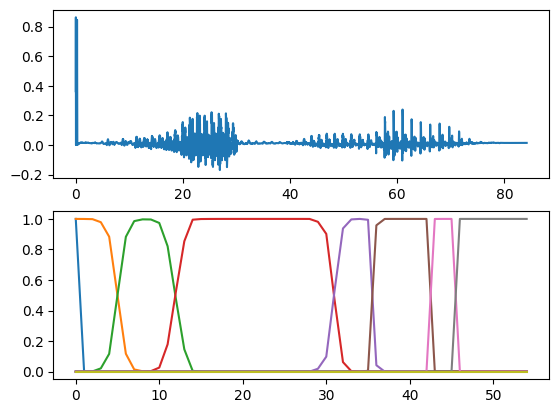

--- iteration 14 ---
4.797638820098678e-153


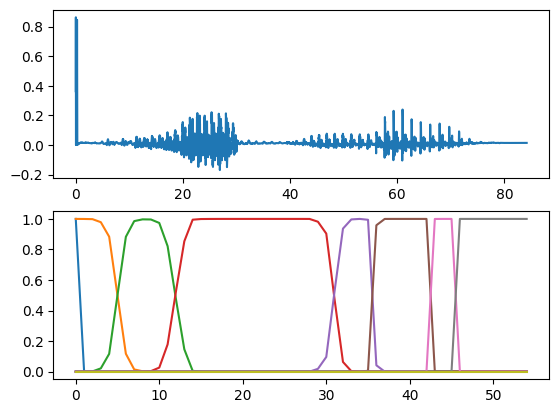

--- iteration 15 ---
4.79785460360738e-153


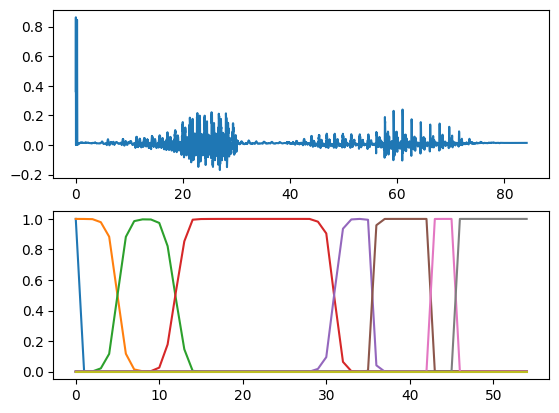

--- iteration 16 ---
4.79793364006516e-153


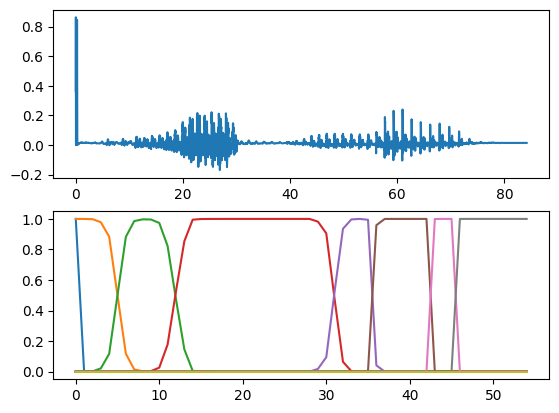

--- iteration 17 ---
4.797962593574509e-153


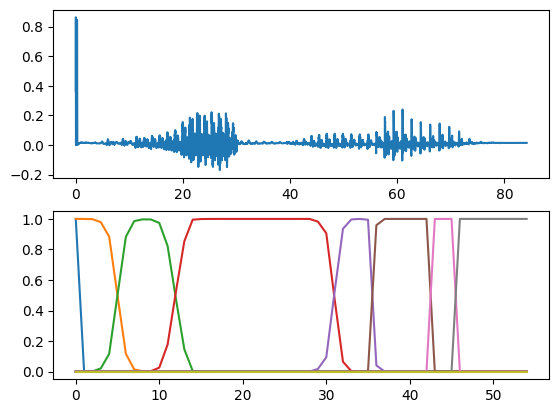

--- iteration 18 ---
4.797973201799682e-153


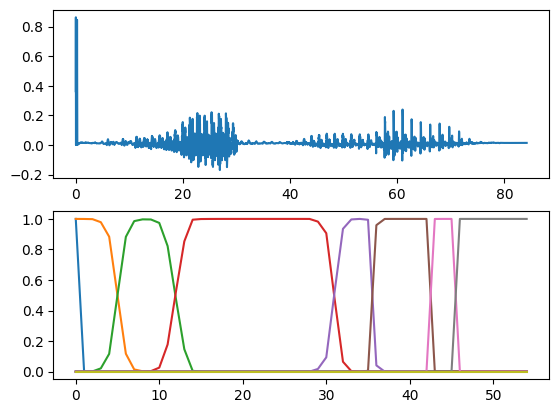

--- iteration 19 ---
4.797977089031217e-153


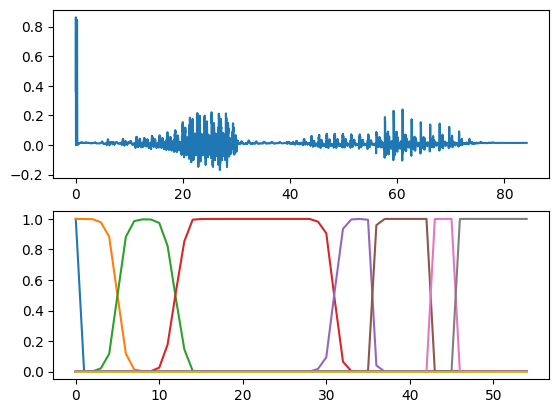

In [ ]:
NEWA, NEWMI, NEWSIGMA, Ptot, ALFA, BETA, L = reestim(LPCC_train["1"], A, MI, SIGMA)
for iter in np.arange(20):
    print(f'--- iteration {iter} ---');
    NEWA, NEWMI, NEWSIGMA, Ptot, ALFA, BETA, L = reestim(LPCC_train["1"], NEWA, NEWMI, SIGMA)
    print(Ptot)
    f, ax = plt.subplots(2)
    ax[0].plot(np.arange(len(train_orig["1"]))/T, train_orig["1"])
    for j in range(L.shape[1]):
        ax[1].plot (np.arange(T), L[:,j])
    plt.show()

#### Q: How does the functions $L_j(t)$ change during the training?

#### Q: Are the 20 step necessary? How would you improve the training?

#### Q: Why do we need the normalization in the reestim algorithm?

### 2.2 Recognition - Viterbi algorithm

#### 2.2.1 Training
First train the models for all words.

  0%|          | 0/10 [00:00<?, ?it/s]

Ptot 0.0: 100%|██████████| 10/10 [00:08<00:00,  1.17it/s]


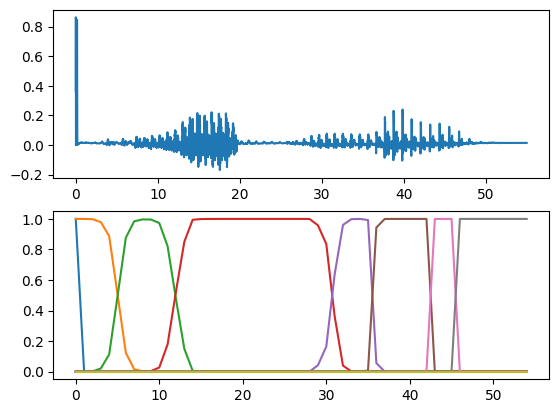

Ptot 7.322672688974224e+34: 100%|██████████| 10/10 [00:05<00:00,  1.78it/s]


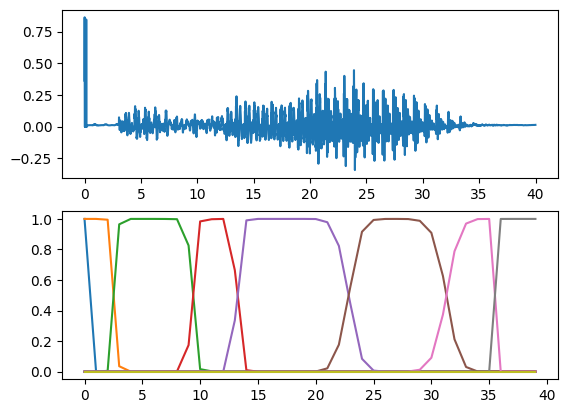

Ptot 1.3182414337000125e+18: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


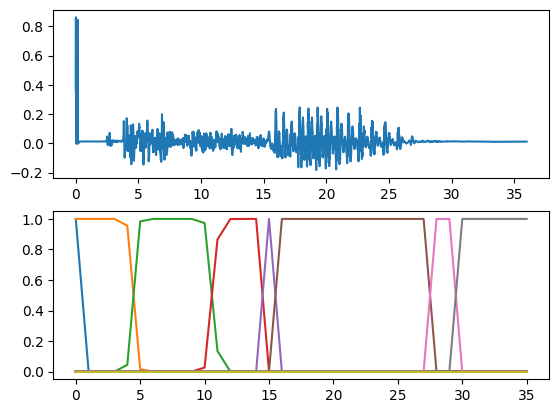

Ptot 0.0: 100%|██████████| 10/10 [00:07<00:00,  1.42it/s]


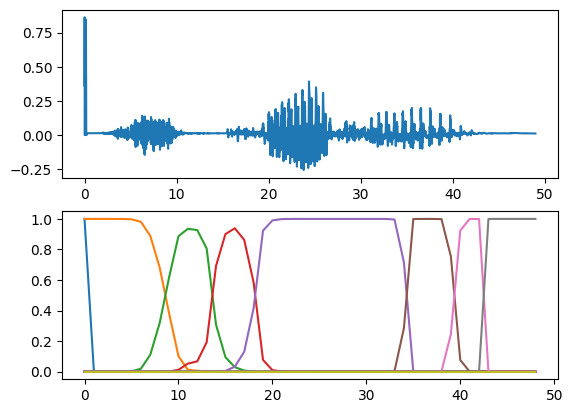

In [446]:
def train_hmm(c,s):
    N=9 # number of states
    T = c.shape[0]
    A = inittran(N)
    MI, SIGMA = initemis(c.T,N)
    pbar = tqdm(np.arange(10))
    for i in pbar:
        A, MI, _, Ptot, ALFA, BETA, L = reestim(c, A, MI, SIGMA)
        pbar.set_description(f"Ptot {np.round(Ptot, 3)}")
        
    f, ax = plt.subplots(2)
    ax[0].plot(np.arange(len(s))/len(s)*T, s)
    for j in range(L.shape[1]):
        ax[1].plot (np.arange(T), L[:,j])
    plt.show()
    return A, MI, SIGMA


A1, MI1, S1 = train_hmm(LPCC_train["1"], train_orig["1"])
A2, MI2, S2 = train_hmm(LPCC_train["2"], train_orig["2"])
A3, MI3, S3 = train_hmm(LPCC_train["3"], train_orig["3"])
A4, MI4, S4 = train_hmm(LPCC_train["4"], train_orig["4"])

#### Q: What is the difference between Ptot and Ptott? How do they change during training?
#### Q: Check the values of Ptot - what do they represent? Why do they change at every iteration so much?

#### 2.2.2 Recognition
The recognition is made based ont he Viterbi algorithm (`viterbi_log` function)

In [451]:
def viterbi_log(O, A, MI, SIGMA):
    T,P = O.shape
    N = A.shape[0]
    A = 1e-200 + A #log 0
    FI = np.zeros((N,T))
    XX = np.zeros((N,T))
    X = np.zeros((T), dtype=np.int_)
    # init
    FI[0,0] = 1;
    for j in np.arange(1 , N-1):
        FI[j,0] = np.log(A[0,j]) + sts.multivariate_normal.logpdf(O[0], mean=MI[j], cov=SIGMA[j]**2)

    # cycle
    for t in np.arange(1, T):
        for j in np.arange(1, N-1):
            mm =    np.max(FI[1:(N-1),t-1]+np.log(A[1:N-1,j]))
            ii = np.argmax(FI[1:(N-1),t-1]+np.log(A[1:N-1,j]))
            ii +=1
            XX[j,t] = ii
            emis = sts.multivariate_normal.logpdf(O[t], mean=MI[j], cov=SIGMA[j]**2)
            FI[j,t] = mm + emis

    # final
    mm = np.max(FI[1:N-1,T-1] + np.log(A[1:(N-1),N-1]))
    ii =  np.argmax(FI[1:N-1,T-1] + np.log(A[1:(N-1),N-1]))
    ii += 1
    XX[-1,-1] = ii
    Pvit = mm

    # backtrace
    X[-1] = XX[-1,-1]
    for t in np.arange(T-2,-1,-1):
        X[t] = XX[X[t+1], t+1]
    
    return Pvit, X

def hmm_reco(O, exp):
    out = [viterbi_log(O, A1, MI1, S1)[0],
                     viterbi_log(O, A2, MI2, S2)[0],
                     viterbi_log(O, A3, MI3, S3)[0],
                     viterbi_log(O, A4, MI4, S4)[0]]
    return print(f'Recognized {np.argmax(out)+1}, expected {exp}, log_prob {out}')

hmm_reco(LPCC_train["1"], 1)
hmm_reco(LPCC_train["2"], 2)
hmm_reco(LPCC_train["3"], 3)
hmm_reco(LPCC_train["4"], 4)
hmm_reco(LPCC_test["1t"], 1)
hmm_reco(LPCC_test["2t"], 2)
hmm_reco(LPCC_test["3t"], 3)
hmm_reco(LPCC_test["4t"], 4)
hmm_reco(LPCC_test["1l"], 1)
hmm_reco(LPCC_test["2l"], 2)
hmm_reco(LPCC_test["b"], "bedna")


Recognized 1, expected 1, log_prob [-353.5873842996601, -2018.6507584724343, -1549.0213019364844, -671.6671147784998]
Recognized 2, expected 2, log_prob [-312.786824998438, 77.74234415671424, -159.67818431035906, -221.1926388545445]
Recognized 3, expected 3, log_prob [-276.6971397750372, -142.04589924250675, 41.51321639014043, -187.38107109637878]
Recognized 4, expected 4, log_prob [-389.9834602133429, -720.107616181774, -445.8744131490358, -179.08034066526992]
Recognized 1, expected 1, log_prob [-1265.1149823782919, -14650.10508132265, -16628.20769393197, -7367.098442562763]
Recognized 2, expected 2, log_prob [-279.9092477958565, -95.86838331398296, -97.07199563267251, -201.98162493498333]
Recognized 1, expected 3, log_prob [-255.00833253213005, -1193.5742631910246, -566.3477188962773, -296.7751851226745]
Recognized 4, expected 4, log_prob [-412.24917448999446, -605.194838429477, -346.07415798363064, -225.30868892397012]
Recognized 1, expected 1, log_prob [-551.3883755625399, -1751.65

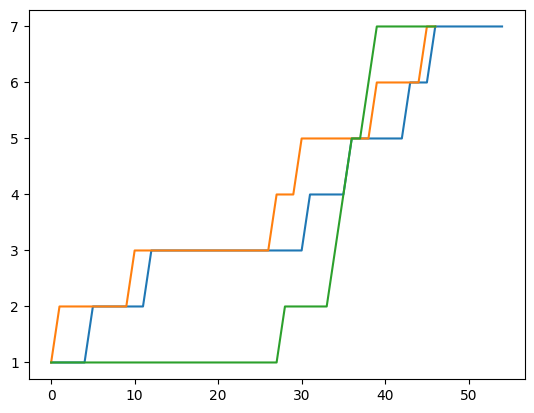

In [454]:
plt.plot(viterbi_log(LPCC_train["1"], A1, MI1, S1)[1])
plt.plot(viterbi_log(LPCC_test["1t"], A1, MI1, S1)[1])
plt.plot(viterbi_log(LPCC_test["1t"], A2, MI2, S2)[1])

#### Q: Check the functions $L_j(t)$, did the BW algorithm find frame segments?

#### Q: In the third model there is a $L_j(t)$ function which is just one frame long. Is it correct? Why?

#### Q: What information do you get from the Viterbi log values?
